# Proyek Klasifikasi Gambar: Fruits Classification 🍇
- **Nama:** Dila Aura Futri
- **Email:** mrkhyuck.dila@gmail.com
- **ID Dicoding:** [Input Username]

## Import Semua Packages/Library yang Digunakan

In [3]:
# Library yang sering digunakan
import os, shutil
import zipfile
import random
from random import sample
import shutil
from shutil import copyfile
import pathlib
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm as tq
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns


# Libraries untuk pemrosesan data gambar
import cv2
from PIL import Image
import skimage
from skimage import io
from skimage.transform import resize
from skimage.transform import rotate, AffineTransform, warp
from skimage import img_as_ubyte
from skimage.exposure import adjust_gamma
from skimage.util import random_noise


# Libraries untuk pembangunan model
import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras import Model, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.layers import InputLayer, Conv2D, SeparableConv2D, MaxPooling2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [4]:
# Mencetak versi TensorFlow yang sedang digunakan
print(tf.__version__)

2.19.0


## Data Preparation

### Data Loading

In [5]:
# Import module yang disediakan google colab untuk kebutuhan upload file
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"dilalovegood","key":"e45175e6f73621e86bbaa97954175923"}'}

In [6]:
!rm -rf fruits-classification/

In [7]:
# Pastikan kaggle API key sudah diunggah ke Colab
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [8]:
# Download dataset dengan nama yang benar
!kaggle datasets download -d utkarshsaxenadn/fruits-classification

Dataset URL: https://www.kaggle.com/datasets/utkarshsaxenadn/fruits-classification
License(s): CC0-1.0


In [9]:
# Ekstrak dataset
!unzip fruits-classification.zip -d fruits-classification


#https://www.kaggle.com/datasets/utkarshsaxenadn/fruits-classification/code

Output streaming akan dipotong hingga 5000 baris terakhir.
  inflating: fruits-classification/Fruits Classification/train/Grape/Grape (1950).jpeg  
  inflating: fruits-classification/Fruits Classification/train/Grape/Grape (1952).jpeg  
  inflating: fruits-classification/Fruits Classification/train/Grape/Grape (1953).jpeg  
  inflating: fruits-classification/Fruits Classification/train/Grape/Grape (1955).jpeg  
  inflating: fruits-classification/Fruits Classification/train/Grape/Grape (1956).jpeg  
  inflating: fruits-classification/Fruits Classification/train/Grape/Grape (1957).jpeg  
  inflating: fruits-classification/Fruits Classification/train/Grape/Grape (1958).jpeg  
  inflating: fruits-classification/Fruits Classification/train/Grape/Grape (1959).jpeg  
  inflating: fruits-classification/Fruits Classification/train/Grape/Grape (196).jpeg  
  inflating: fruits-classification/Fruits Classification/train/Grape/Grape (1960).jpeg  
  inflating: fruits-classification/Fruits Classifica

### Data Preprocessing

In [10]:
import os
import shutil

In [11]:
import os

# Cek apakah folder utama ada
print("Cek folder utama:", os.path.exists("fruits-classification"))

# Cek apakah subfolder train ada
print("Cek folder train:", os.path.exists("fruits-classification/train"))

# Cek apakah subfolder test ada
print("Cek folder test:", os.path.exists("fruits-classification/test"))

# Cek apakah subfolder valid ada
print("Cek folder valid:", os.path.exists("fruits-classification/valid"))


Cek folder utama: True
Cek folder train: False
Cek folder test: False
Cek folder valid: False


In [12]:
import os
import shutil

# Direktori asal untuk train, test, dan validation
train_dir = "fruits-classification/Fruits Classification/train"
test_dir = "fruits-classification/Fruits Classification/test"
valid_dir = "fruits-classification/Fruits Classification/valid"

# Direktori baru untuk dataset gabungan
combined_dir = "fruits-classification/dataset_combined"

# Buat direktori baru untuk dataset gabungan
os.makedirs(combined_dir, exist_ok=True)

# Fungsi untuk menyalin data ke direktori gabungan
def copy_data(source_dir, target_dir):
    for category in os.listdir(source_dir):
        category_dir = os.path.join(source_dir, category)
        if os.path.isdir(category_dir):
            shutil.copytree(category_dir, os.path.join(target_dir, category), dirs_exist_ok=True)

# Salin file dan folder dari train, test, dan validation
copy_data(train_dir, combined_dir)
copy_data(test_dir, combined_dir)
copy_data(valid_dir, combined_dir)

print("Dataset berhasil digabung ke dalam:", combined_dir)


Dataset berhasil digabung ke dalam: fruits-classification/dataset_combined


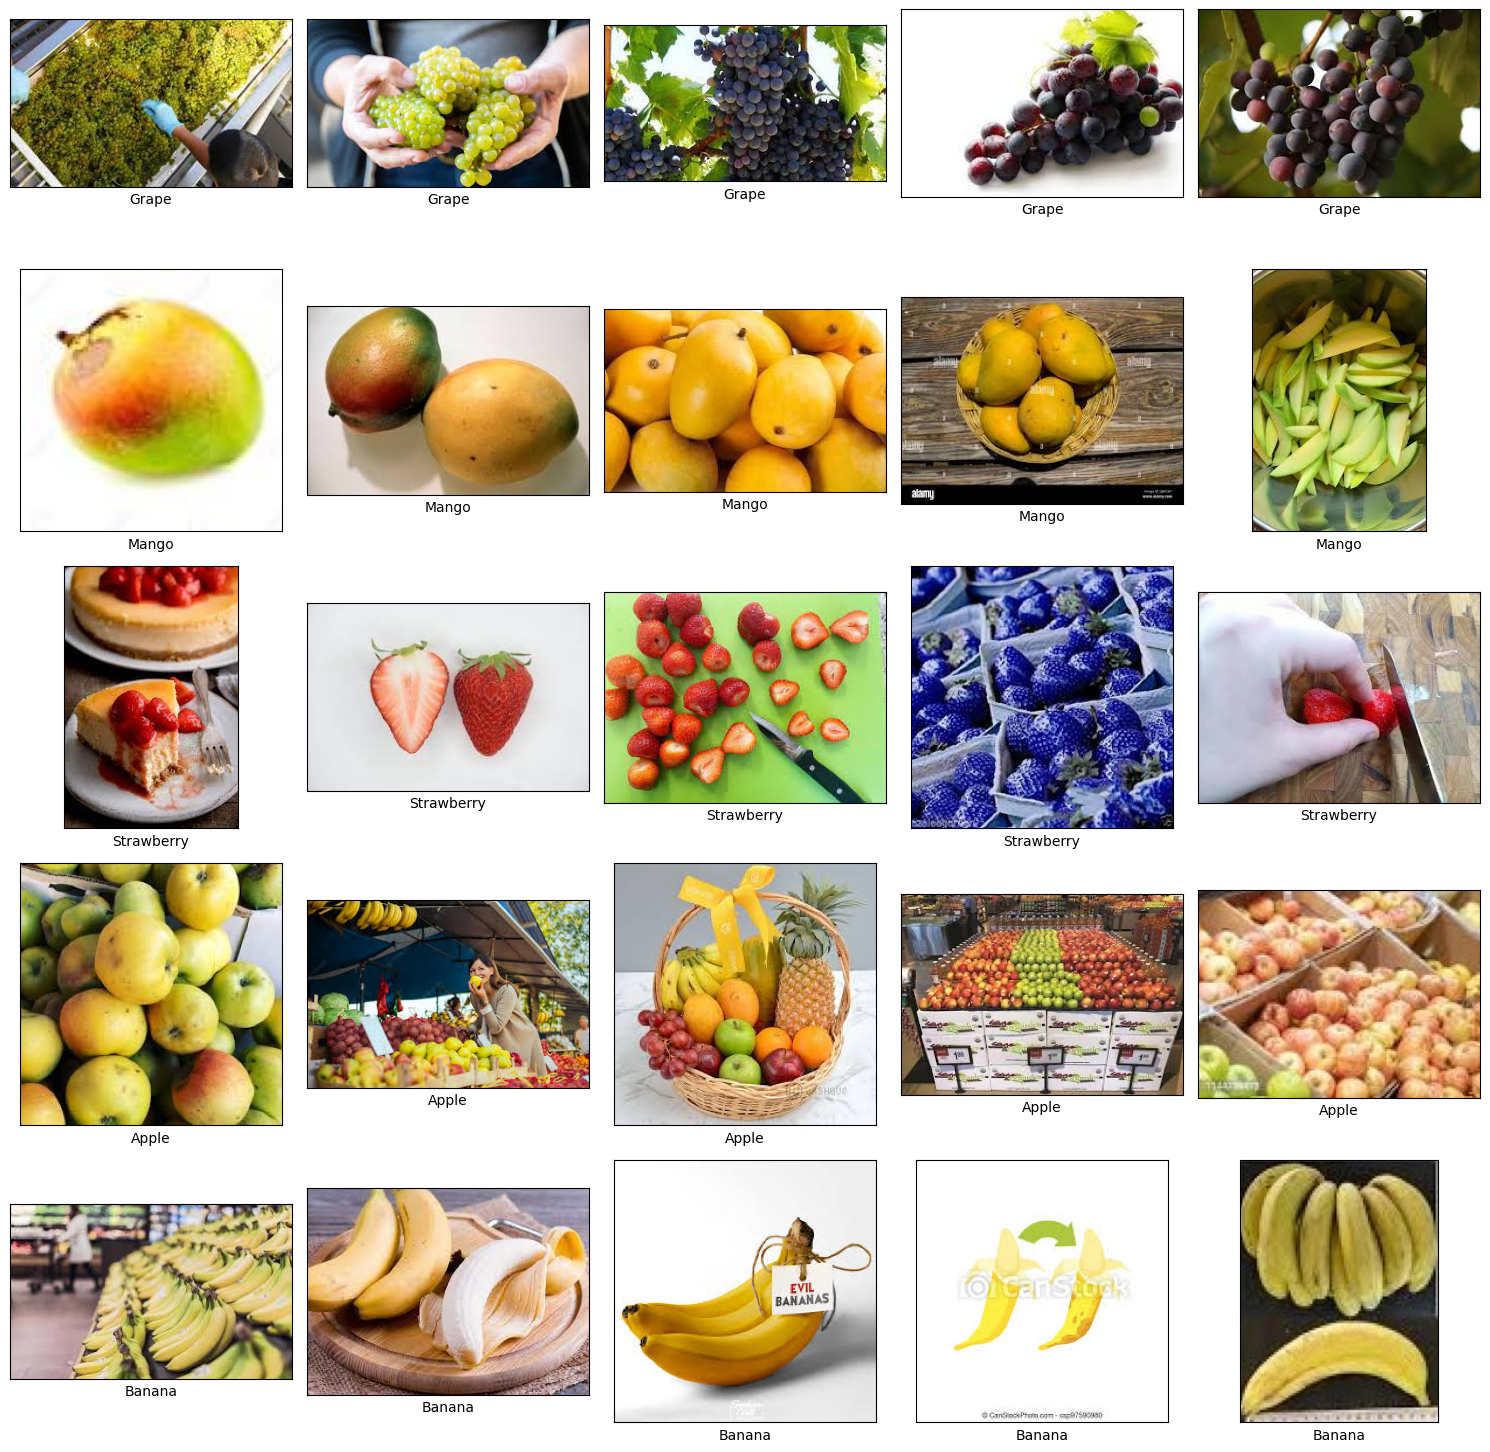

In [13]:
# Membuat kamus yang menyimpan gambar untuk setiap kelas dalam data
fruit_images = {}

# Tentukan path sumber train
path = "fruits-classification/"
path_sub = os.path.join(path, "dataset_combined")
for i in os.listdir(path_sub):
    fruit_images[i] = os.listdir(os.path.join(path_sub, i))

# Menampilkan secara acak 5 gambar di bawah setiap dari 2 kelas dari data.
# Anda akan melihat gambar yang berbeda setiap kali.
path_sub = "fruits-classification/dataset_combined"

# Menampilkan secara acak 5 gambar di bawah setiap kelas dari data latih
fig, axs = plt.subplots(len(fruit_images.keys()), 5, figsize=(15, 15))

for i, class_name in enumerate(os.listdir(path_sub)):
    images = np.random.choice(fruit_images[class_name], 5, replace=False)

    for j, image_name in enumerate(images):
        img_path = os.path.join(path_sub, class_name, image_name)
        img = Image.open(img_path)
        axs[i, j].imshow(img)
        axs[i, j].set(xlabel=class_name, xticks=[], yticks=[])


fig.tight_layout()

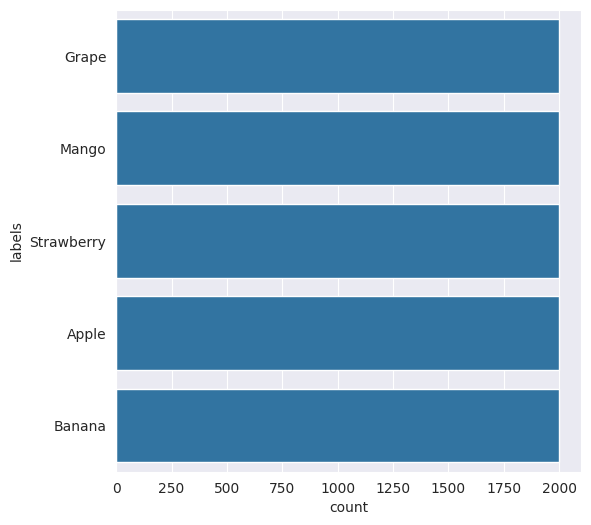

In [14]:
# Define source path
fruit_path = "fruits-classification/dataset_combined"

# Create a list that stores data for each filenames, filepaths, and labels in the data
file_name = []
labels = []
full_path = []

# Get data image filenames, filepaths, labels one by one with looping, and store them as dataframe
for path, subdirs, files in os.walk(fruit_path):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)

distribution_train = pd.DataFrame({"path":full_path,'file_name':file_name,"labels":labels})

# Plot the distribution of images across the classes
Label = distribution_train['labels']
plt.figure(figsize = (6,6))
sns.set_style("darkgrid")
plot_data = sns.countplot(Label)

#### Split Dataset

In [15]:
# Panggil variabel mypath yang menampung folder dataset gambar
mypath= 'fruits-classification/dataset_combined'

file_name = []
labels = []
full_path = []
for path, subdirs, files in os.walk(mypath):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)


# Memasukan variabel yang sudah dikumpulkan pada looping di atas menjadi sebuah dataframe agar rapih
df = pd.DataFrame({"path":full_path,'file_name':file_name,"labels":labels})
# Melihat jumlah data gambar pada masing-masing label
df.groupby(['labels']).size()

labels
Apple         2000
Banana        2000
Grape         2000
Mango         2000
Strawberry    2000
dtype: int64

In [16]:
# Variabel yang digunakan pada pemisahan data ini dimana variabel x = data path dan y = data labels
X= df['path']
y= df['labels']

# Split dataset awal menjadi data train dan test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=300)

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=300)

In [17]:
# Menyatukan kedalam masing-masing dataframe
df_tr = pd.DataFrame({'path':X_train,'labels':y_train,'set':'train'})
df_te = pd.DataFrame({'path':X_test,'labels':y_test,'set':'test'})
df_val = pd.DataFrame({'path': X_val, 'labels': y_val, 'set': 'valid'})


In [18]:
# Print hasil diatas untuk melihat panjang size data training dan testing
print('train size', len(df_tr))
print('test size', len(df_te))
print('valid size', len(df_val))

train size 6400
test size 2000
valid size 1600


In [19]:
# Gabungkan Train, Test, dan Validation
df_all = pd.concat([df_tr, df_te, df_val], ignore_index=True)

print('===================================================== \n')
print(df_all.groupby(['set', 'labels']).size(), '\n')
print('===================================================== \n')

# Cek sample data
print(df_all.sample(5))



set    labels    
test   Apple          383
       Banana         417
       Grape          411
       Mango          384
       Strawberry     405
train  Apple         1291
       Banana        1276
       Grape         1250
       Mango         1304
       Strawberry    1279
valid  Apple          326
       Banana         307
       Grape          339
       Mango          312
       Strawberry     316
dtype: int64 


                                                   path  labels    set
6126  fruits-classification/dataset_combined/Mango/M...   Mango  train
5588  fruits-classification/dataset_combined/Apple/A...   Apple  train
6823  fruits-classification/dataset_combined/Banana/...  Banana   test
8441  fruits-classification/dataset_combined/Banana/...  Banana  valid
8172  fruits-classification/dataset_combined/Grape/G...   Grape   test


In [20]:
# Memanggil dataset asli yang berisi keseluruhan data gambar yang sesuai dengan labelnya
datasource_path = "fruits-classification/dataset_combined/"
# Membuat variabel Dataset, dimana nanti menampung data yang telah dilakukan pembagian data training dan testing
dataset_path = "Dataset-Final/"

In [21]:
for index, row in tq(df_all.iterrows()):
    # Deteksi filepath
    file_path = row['path']
    if os.path.exists(file_path) == False:
            file_path = os.path.join(datasource_path,row['labels'],row['image'].split('.')[0])

    # Buat direktori tujuan folder
    if os.path.exists(os.path.join(dataset_path,row['set'],row['labels'])) == False:
        os.makedirs(os.path.join(dataset_path,row['set'],row['labels']))

    # Tentukan tujuan file
    destination_file_name = file_path.split('/')[-1]
    file_dest = os.path.join(dataset_path,row['set'],row['labels'],destination_file_name)

    # Salin file dari sumber ke tujuan
    if os.path.exists(file_dest) == False:
        shutil.copy2(file_path,file_dest)

0it [00:00, ?it/s]

In [22]:
# Define training and test directories
TRAIN_DIR = "Dataset-Final/train/"
TEST_DIR = "Dataset-Final/test/"
VALID_DIR = "Dataset-Final/valid/"

#train path
train_apple = os.path.join(TRAIN_DIR + '/Apple')
train_banana = os.path.join(TRAIN_DIR + '/Banana')
train_grape = os.path.join(TRAIN_DIR + '/Grape')
train_mango = os.path.join(TRAIN_DIR + '/Mango')
train_strawberry = os.path.join(TRAIN_DIR + '/Strawberry')

#test path
test_apple = os.path.join(TEST_DIR + '/Apple')
test_banana = os.path.join(TEST_DIR + '/Banana')
test_grape = os.path.join(TEST_DIR + '/Grape')
test_mango = os.path.join(TEST_DIR + '/Mango')
test_strawberry = os.path.join(TEST_DIR + '/Strawberry')

#valid path
valid_apple = os.path.join(VALID_DIR + '/Apple')
valid_banana = os.path.join(VALID_DIR + '/Banana')
valid_grape = os.path.join(VALID_DIR + '/Grape')
valid_mango = os.path.join(VALID_DIR + '/Mango')
valid_strawberry = os.path.join(VALID_DIR + '/Strawberry')

#total images in training
print("Total number of apple images in training set: ",len(os.listdir(train_apple)))
print("Total number of banana images in training set: ",len(os.listdir(train_banana)))
print("Total number of grape images in training set: ",len(os.listdir(train_grape)))
print("Total number of mango images in training set: ",len(os.listdir(train_mango)))
print("Total number of strawberry images in training set: ",len(os.listdir(train_strawberry)))

#total images in test
print("Total number of apple images in test set: ",len(os.listdir(test_apple)))
print("Total number of banana images in test set: ",len(os.listdir(test_banana)))
print("Total number of grape images in test set: ",len(os.listdir(test_grape)))
print("Total number of mango images in test set: ",len(os.listdir(test_mango)))
print("Total number of strawberry images in test set: ",len(os.listdir(test_strawberry)))

#total images in valid
print("Total number of apple images in valid set: ",len(os.listdir(valid_apple)))
print("Total number of banana images in valid set: ",len(os.listdir(valid_banana)))
print("Total number of grape images in valid set: ",len(os.listdir(valid_grape)))
print("Total number of mango images in valid set: ",len(os.listdir(valid_mango)))
print("Total number of strawberry images in valid set: ",len(os.listdir(valid_strawberry)))

Total number of apple images in training set:  1291
Total number of banana images in training set:  1276
Total number of grape images in training set:  1250
Total number of mango images in training set:  1304
Total number of strawberry images in training set:  1279
Total number of apple images in test set:  383
Total number of banana images in test set:  417
Total number of grape images in test set:  411
Total number of mango images in test set:  384
Total number of strawberry images in test set:  405
Total number of apple images in valid set:  326
Total number of banana images in valid set:  307
Total number of grape images in valid set:  339
Total number of mango images in valid set:  312
Total number of strawberry images in valid set:  316


In [23]:
# Create an ImageDataGenerator object normalizing the images
datagen = ImageDataGenerator(rescale=1/255.,
                             validation_split = 0.2,
                             rotation_range=20,
                             width_shift_range=0.2,
                             height_shift_range=0.2,
                             shear_range=0.2,
                             zoom_range=0.2,
                             horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = datagen.flow_from_directory(TRAIN_DIR,
                                              batch_size=32,
                                              target_size=(224,224),
                                              color_mode="rgb",  # Ubah ke RGB
                                              class_mode='categorical',  # Pakai categorical untuk multi-class
                                              subset='training',
                                              shuffle=True)

validation_generator = datagen.flow_from_directory(VALID_DIR,
                                                   batch_size=32,
                                                   target_size=(224,224),
                                                   color_mode="rgb",  # Ubah ke RGB
                                                   class_mode='categorical',
                                                   subset='validation',
                                                   shuffle=False)

test_generator = test_datagen.flow_from_directory(TEST_DIR,
                                                  batch_size=1,
                                                  target_size=(224,224),
                                                  color_mode="rgb",  # Ubah ke RGB
                                                  class_mode='categorical',
                                                  shuffle=False)



Found 5122 images belonging to 5 classes.
Found 318 images belonging to 5 classes.
Found 2000 images belonging to 5 classes.


In [24]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

# Load MobileNetV2 dengan input_shape yang valid (sesuai dengan model pre-trained)
base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
base_model.trainable = False  # Freeze layers

# Tambahkan lapisan di atas base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dense(64, activation='relu')(x)
output_layer = Dense(5, activation='softmax')(x)  # 5 kelas buah

# Buat model
model = Model(inputs=base_model.input, outputs=output_layer)

# Compile model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 112, 112, 32)   │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 112, 112, 32)   │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 112, 112, 32)   │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 112, 112, 32)   │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 112, 112, 16)   │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 112, 112, 16)   │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 112, 112, 96)   │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 112, 112, 96)   │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 112, 112, 96)   │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 113, 113, 96)   │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 56, 56, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise_BN 

 Total params: 2,430,533 (9.27 MB)

 Trainable params: 172,549 (674.02 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

## Modelling

In [25]:
# Load MobileNetV2 sebagai feature extractor
base_model = MobileNetV2(input_shape=(224,224,3), include_top=False, weights='imagenet')
base_model.trainable = True  # Unfreeze agar bisa fine-tuning

# Buka hanya 20 layer terakhir untuk fine-tuning
for layer in base_model.layers[:-20]:
    layer.trainable = False

# Tambahkan layer baru
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)  # Tambahkan dropout
x = Dense(64, activation='relu')(x)
x = Dropout(0.3)(x)  # Tambahkan dropout lagi
output = Dense(5, activation='softmax')(x)

# Bangun model
model = Model(inputs=base_model.input, outputs=output)

# Compile model dengan Adam (learning rate 0.0001)
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [26]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Callbacks untuk early stopping dan learning rate reduction
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)
checkpoint = ModelCheckpoint("best_model.h5", monitor='val_accuracy', save_best_only=True)

count_apple, count_banana, count_grape, count_mango, count_strawberry = len(os.listdir(train_apple)), len(os.listdir(train_banana)), len(os.listdir(train_grape)), len(os.listdir(train_mango)), len(os.listdir(train_strawberry))
weight_0 = (1 / count_apple) * (count_apple + count_banana + count_grape + count_mango + count_strawberry) / 5.0
weight_1 = (1 / count_banana) * (count_apple + count_banana + count_grape + count_mango + count_strawberry) / 5.0
weight_2 = (1 / count_grape) * (count_apple + count_banana + count_grape + count_mango + count_strawberry) / 5.0
weight_3 = (1 / count_mango) * (count_apple + count_banana + count_grape + count_mango + count_strawberry) / 5.0
weight_4 = (1 / count_strawberry) * (count_apple + count_banana + count_grape + count_mango + count_strawberry) / 5.0

class_weights = {0 : weight_0, 1 : weight_1, 2: weight_2, 3: weight_3, 4: weight_4}

%time


# Training model dengan callbacks yang sudah didefinisikan
history = model.fit(
    train_generator,
    epochs=30,
    validation_data=validation_generator,
    class_weight=class_weights,
    callbacks=[early_stopping, reduce_lr, checkpoint]
)


CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 5.01 µs


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step - accuracy: 0.4503 - loss: 1.3334

161/161 ━━━━━━━━━━━━━━━━━━━━ 98s 496ms/step - accuracy: 0.4512 - loss: 1.3316 - val_accuracy: 0.7579 - val_loss: 0.7926 - learning_rate: 1.0000e-04
Epoch 2/30
161/161 ━━━━━━━━━━━━━━━━━━━━ 62s 385ms/step - accuracy: 0.7729 - loss: 0.6290 - val_accuracy: 0.7358 - val_loss: 0.8432 - learning_rate: 1.0000e-04
Epoch 3/30
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step - accuracy: 0.8402 - loss: 0.4727

161/161 ━━━━━━━━━━━━━━━━━━━━ 82s 387ms/step - accuracy: 0.8402 - loss: 0.4728 - val_accuracy: 0.7673 - val_loss: 0.8216 - learning_rate: 1.0000e-04
Epoch 4/30
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.8503 - loss: 0.4385

161/161 ━━━━━━━━━━━━━━━━━━━━ 64s 395ms/step - accuracy: 0.8503 - loss: 0.4384 - val_accuracy: 0.8176 - val_loss: 0.6686 - learning_rate: 1.0000e-04
Epoch 5/30
161/161 ━━━━━━━━━━━━━━━━━━━━ 81s 389ms/step - accuracy: 0.8901 - loss: 0.3329 - val_accuracy: 0.8113 - val_loss: 0.7082 - learning_rate: 1.0000e-04
Epoch 6/30
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step - accuracy: 0.8944 - loss: 0.3032

161/161 ━━━━━━━━━━━━━━━━━━━━ 62s 388ms/step - accuracy: 0.8944 - loss: 0.3032 - val_accuracy: 0.8270 - val_loss: 0.6917 - learning_rate: 1.0000e-04
Epoch 7/30
161/161 ━━━━━━━━━━━━━━━━━━━━ 64s 397ms/step - accuracy: 0.9014 - loss: 0.3041 - val_accuracy: 0.7767 - val_loss: 0.8737 - learning_rate: 1.0000e-04
Epoch 8/30
161/161 ━━━━━━━━━━━━━━━━━━━━ 62s 386ms/step - accuracy: 0.9135 - loss: 0.2556 - val_accuracy: 0.8113 - val_loss: 0.7055 - learning_rate: 2.0000e-05
Epoch 9/30
161/161 ━━━━━━━━━━━━━━━━━━━━ 62s 383ms/step - accuracy: 0.9181 - loss: 0.2442 - val_accuracy: 0.8050 - val_loss: 0.7039 - learning_rate: 2.0000e-05


## Evaluasi dan Visualisasi

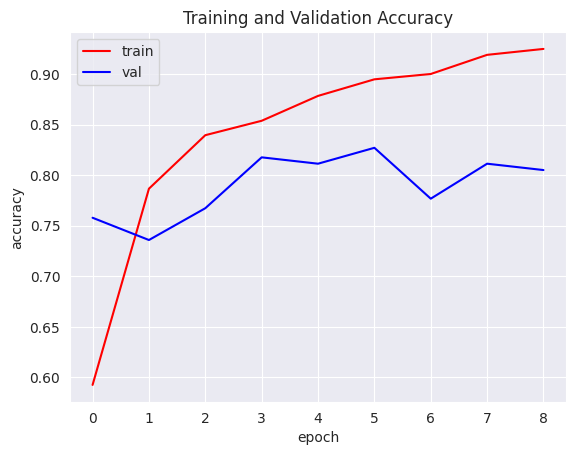

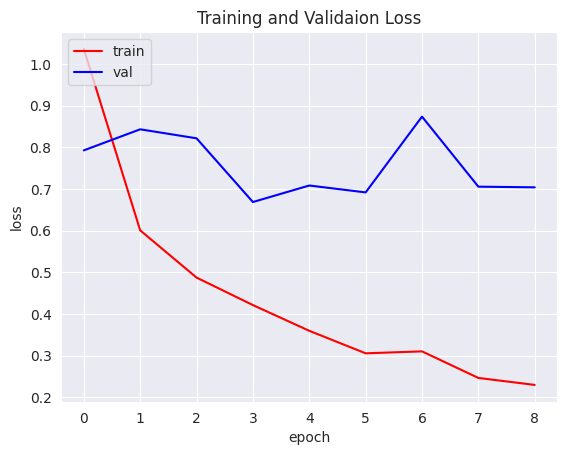

In [27]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and Validation Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title('Training and Validaion Loss')
plt.show()



              precision    recall  f1-score   support

       Apple     0.7589    0.8303    0.7930       383
      Banana     0.9826    0.6763    0.8011       417
       Grape     0.9312    0.7908    0.8553       411
       Mango     0.7416    0.9193    0.8209       384
  Strawberry     0.8294    0.9605    0.8902       405

    accuracy                         0.8335      2000
   macro avg     0.8488    0.8354    0.8321      2000
weighted avg     0.8519    0.8335    0.8325      2000



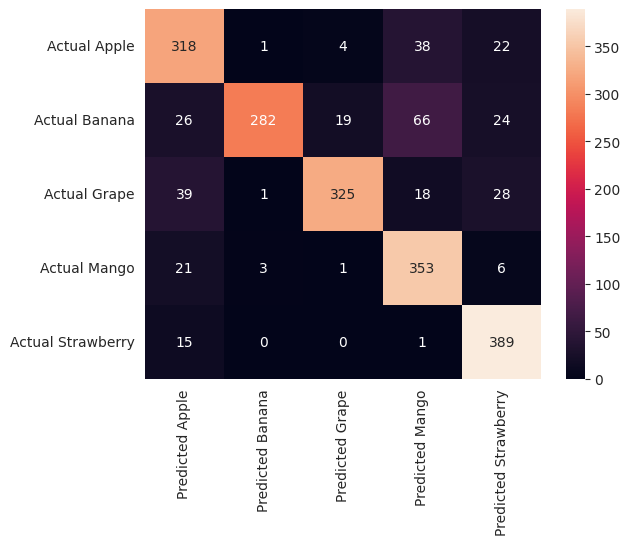

In [28]:

  # Dapatkan prediksi dari model
  preds_prob = model.predict(test_generator, verbose=0)

  # Konversi probabilitas menjadi label kelas
  preds_classes = np.argmax(preds_prob, axis=1)

    # Pastikan variabel preds_classes telah didefinisikan seperti pada solusi sebelumnya

  # Gunakan preds_classes untuk evaluasi
  cm = pd.DataFrame(data=confusion_matrix(test_generator.classes, preds_classes, labels=[0, 1, 2, 3, 4]),
                    index=["Actual Apple", "Actual Banana", "Actual Grape", "Actual Mango", "Actual Strawberry"],
                    columns=["Predicted Apple", "Predicted Banana", "Predicted Grape", "Predicted Mango", "Predicted Strawberry"])
  sns.heatmap(cm, annot=True, fmt="d")

  print("\n")
  print(classification_report(y_true=test_generator.classes, y_pred=preds_classes,
                              target_names=['Apple', 'Banana', 'Grape', 'Mango', 'Strawberry'], digits=4))



5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


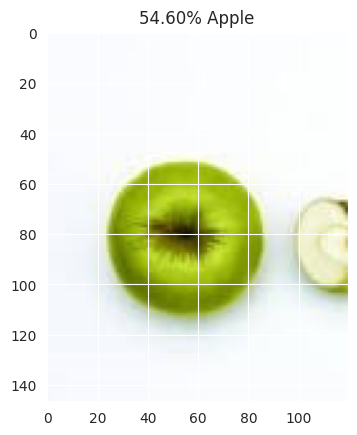

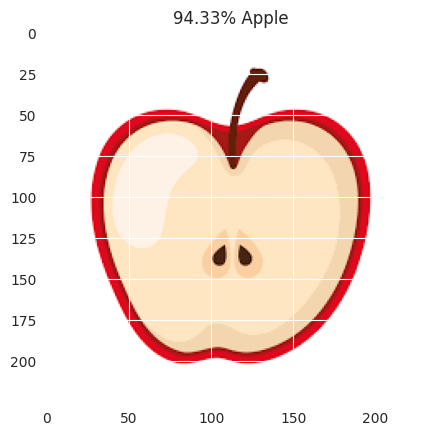

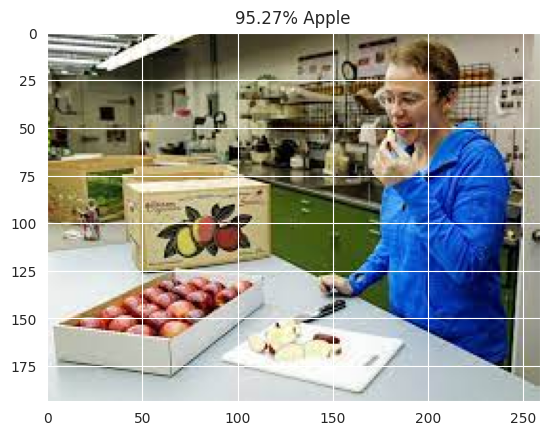

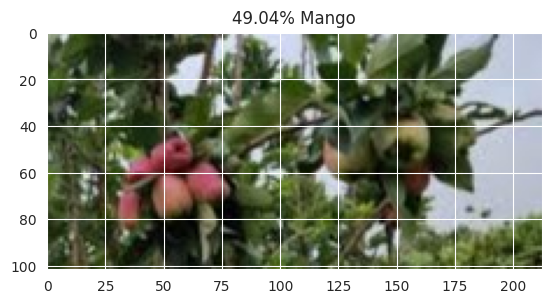

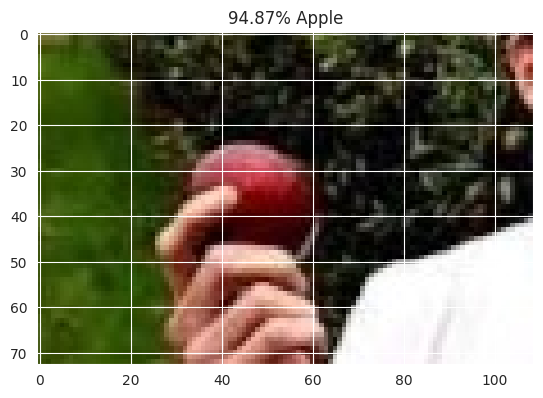

In [29]:
# Prediksi probabilitas untuk semua kelas
probabilities = model.predict(test_generator, steps =5, verbose=1)

class_labels = ['Apple', 'Banana', 'Grape', 'Mango', 'Strawberry']

# Loop untuk menampilkan gambar dan hasil prediksi
for index, probability in enumerate(probabilities):
    image_path = TEST_DIR + "/" + test_generator.filenames[index]
    img = mpimg.imread(image_path)
    plt.imshow(img)

    # Ambil indeks kelas dengan probabilitas tertinggi
    predicted_class = np.argmax(probability)
    predicted_label = class_labels[predicted_class]
    confidence = probability[predicted_class] * 100  # Ubah ke persen

    plt.title(f"{confidence:.2f}% {predicted_label}")
    plt.show()

## Konversi Model

In [30]:
!pip install tensorflowjs


In [34]:
import tensorflow as tf
import os
import shutil
from google.colab import files

# === 1️⃣ Buat Direktori Submission ===
submission_dir = "submission"
os.makedirs(f"{submission_dir}/tfjs_model", exist_ok=True)
os.makedirs(f"{submission_dir}/tflite", exist_ok=True)
os.makedirs(f"{submission_dir}/saved_model", exist_ok=True)

# === 2️⃣ Simpan Model dalam Format SavedModel ===
model.export(f"{submission_dir}/saved_model")
print("✅ Model disimpan sebagai SavedModel")

# === 3️⃣ Konversi ke TF-Lite ===
converter = tf.lite.TFLiteConverter.from_saved_model(f"{submission_dir}/saved_model")
tflite_model = converter.convert()

# Simpan model TF-Lite
tflite_path = f"{submission_dir}/tflite/model.tflite"
with open(tflite_path, "wb") as f:
    f.write(tflite_model)
print("✅ Model dikonversi ke TF-Lite")

# Simpan label kelas untuk TF-Lite
class_labels = ['Apple', 'Banana', 'Grape', 'Mango', 'Strawberry']
label_path = f"{submission_dir}/tflite/label.txt"
with open(label_path, "w") as f:
    for label in class_labels:
        f.write(label + "\n")
print("✅ Label kelas disimpan dalam label.txt")

# === 4️⃣ Konversi ke TFJS ===
import tensorflowjs as tfjs
tfjs_path = f"{submission_dir}/tfjs_model"
tfjs.converters.save_keras_model(model, tfjs_path)
print("✅ Model dikonversi ke TFJS")

# === 5️⃣ ZIP Folder Submission ===
shutil.make_archive("submission", 'zip', "submission")
files.download("submission.zip")
print("✅ Folder submission.zip berhasil dibuat dan siap di-download!")


Saved artifact at 'submission/saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_158')
Output Type:
  TensorSpec(shape=(None, 5), dtype=tf.float32, name=None)
Captures:
  135382094402512: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135381940329872: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135381940329488: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135382094403280: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135382094402896: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135381940331600: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135381940331984: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135381940332368: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135381940332176: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135381940331024: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1353

✅ Model dikonversi ke TF-Lite
✅ Label kelas disimpan dalam label.txt
failed to lookup keras version from the file,
    this is likely a weight only file
✅ Model dikonversi ke TFJS


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ Folder submission.zip berhasil dibuat dan siap di-download!


In [36]:
!pip install pipreqs
!pipreqs /content --force
from google.colab import files
files.download("requirements.txt")


INFO: Not scanning for jupyter notebooks.
Please, verify manually the final list of requirements.txt to avoid possible dependency confusions.
INFO: Successfully saved requirements file in /content/requirements.txt


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Inference (Optional)